In [30]:
import io
import nbformat
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MultiLabelBinarizer

import re
import csv


In [5]:
data = "train_data.csv"
df1 = pd.read_csv(data)

In [6]:
data = "train_data.csv"
df1 = pd.read_csv(data)

#Prepare card id and ip id for plotting

# # 1.Card ID
# card_enc = LabelBinarizer()
# df1['card_id'] = card_enc.fit_transform(df1[])

#
# # 2.IP ID
# ip_enc = LabelBinarizer()
# df1['ip_id'] = ip_enc.fit_transform(df1.ip_id)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
lb = LabelBinarizer()
y = lb.fit_transform(df1['issuercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['issuercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('issuercountrycode', axis=1), df2], axis=1)

y = lb.fit_transform(df1['shoppercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['shoppercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shoppercountrycode', axis=1), df2], axis=1)

def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

lb2 = LabelBinarizer()
y = lb2.fit_transform(df1['txvariantcode'])

# Create a new DataFrame with the transformed 'txvariantcode' column
df2 = pd.DataFrame(y, columns=['txvariantcode_'+str(i) for i in range(y.shape[1])])

# Replace the 'txvariantcode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('txvariantcode', axis=1), df2], axis=1)

lb3 = LabelBinarizer()
y = lb3.fit_transform(df1['currencycode'])

# Create a new DataFrame with the transformed 'currencycode' column
df2 = pd.DataFrame(y, columns=['currencycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'currencycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('currencycode', axis=1), df2], axis=1)

lb4 = LabelBinarizer()
y = lb4.fit_transform(df1['shopperinteraction'])

# Create a new DataFrame with the transformed 'shopperinteraction' column
df2 = pd.DataFrame(y, columns=['shopperinteraction_'+str(i) for i in range(y.shape[1])])

# Replace the 'shopperinteraction' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shopperinteraction', axis=1), df2], axis=1)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

lb5 = LabelBinarizer()
y = lb5.fit_transform(df1['accountcode_cc'])

# Create a new DataFrame with the transformed 'accountcode_cc' column
df2 = pd.DataFrame(y, columns=['accountcode_cc_'+str(i) for i in range(y.shape[1])])

# Replace the 'accountcode_cc' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('accountcode_cc', axis=1), df2], axis=1)

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3


# X = df1[['issuercountrycode','txvariantcode','bin','amount','currencycode','shoppercountrycode','shopperinteraction','cardverificationcodesupplied','cvcresponsecode','accountcode','mail_id','ip_id','card_id','amount_eur','countries_equal']]

In [7]:

# drop id, mail_id, ip_id, card_id
df1 = df1.drop(['Id','mail_id','ip_id','card_id', 'amount', 'accountcode'], axis=1)

In [8]:
# # # Preprocess your dataset here (e.g., encode categorical variables, scale numerical variables, etc.)

# # Separate features and labels
# X = df1.drop('label', axis=1)
# y = df1['label']

# # Split the dataset into a training set (80%) and a testing set (20%)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# # # # # 

In [9]:
# # Create and train the Decision Tree Classifier
# clf = DecisionTreeClassifier(random_state=42)
# clf.fit(X_train, y_train)

In [10]:
# # Make predictions on the test set
# y_pred = clf.predict(X_test)

# # Print the classification report and accuracy
# print(classification_report(y_test, y_pred))
# print('Accuracy:', accuracy_score(y_test, y_pred))

In [11]:
# # use a neural network for classification
# # Create and train the Multi-Layer Perceptron Classifier
# clf = MLPClassifier(random_state=42)
# clf.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = clf.predict(X_test)

# # Print the classification report and accuracy
# print(classification_report(y_test, y_pred))
# print('Accuracy:', accuracy_score(y_test, y_pred))

In [33]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

# Define the number of folds
n_splits = 3

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree = []
accuracy_list_mlp = []

y_predicts_all_dec_tree = []
y_truth_all_dec_tree = []

y_proba_all_dec_tree = []

y_predicts_all_mlp = []
y_truth_all_mlp = []

y_proba_all_mlp = []


round_counter = 0
# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    print('round ', round_counter, ' of ', n_splits)
    round_counter += 1
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_dec_tree.extend(y_proba)
    y_predicts_all_dec_tree.extend(y_pred)
    y_truth_all_dec_tree.extend(y_test)

    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_decision_tree.append(accuracy)

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_mlp.extend(y_proba)
    y_predicts_all_mlp.extend(y_pred)
    y_truth_all_mlp.extend(y_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_mlp.append(accuracy)

# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree)
print("Average accuracy decision tree:", average_accuracy)

# Calculate the average accuracy across all folds for MLP
average_accuracy = np.mean(accuracy_list_mlp)
print("Average accuracy mlp:", average_accuracy)

round  0  of  3
round  1  of  3
round  2  of  3
Average accuracy decision tree: 0.9976480272744067
Average accuracy mlp: 0.9985445187418769


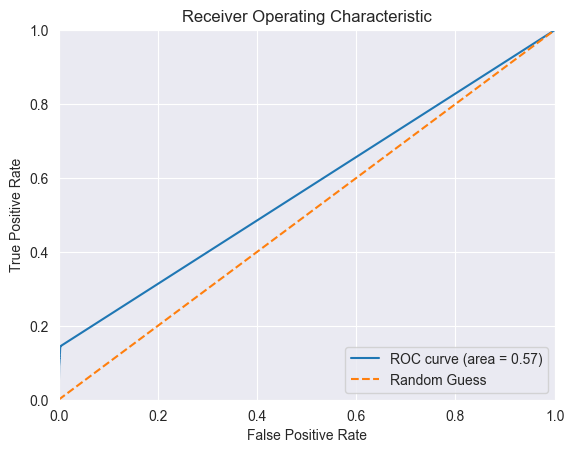

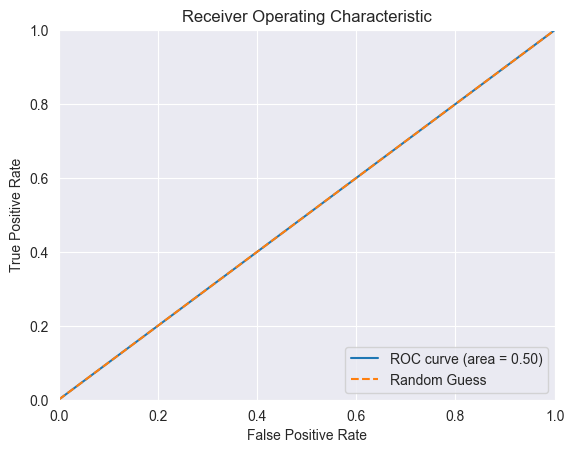

In [52]:
one_prob_dec_tree = [lst[1] for lst in y_proba_all_dec_tree]
fpr, tpr, thresholds = roc_curve(y_truth_all_dec_tree, one_prob_dec_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

one_prob_mlp = [lst[1] for lst in y_proba_all_mlp]
fpr, tpr, thresholds = roc_curve(y_truth_all_mlp, one_prob_mlp)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [48]:
print(np.shape(y_proba_all_dec_tree[::]))

(1, 2)
